# Holt-Winters Exponential Smoothing (additive model, linear trend + seasonality)

#### Holt Winters Smoothing is also known as triple smoothing, since it uses 3 parameters:
- $\alpha$ for the level
- $\gamma$ for the slope/trend
- $\delta$ for the seasonal factors

In [1]:
# getting some warnings from matplotlib, so turning those warnings off
import warnings
warnings.filterwarnings('ignore')

# importing libraries
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# statsmodels documentation on exponential smoothing, simple, Holt, Holt-Winters:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
# reading csv to dataframe
filename = './data/infections2.csv'
df = pd.read_csv(filename)

In [4]:
# inspecting data
df.head(3)

,clostridium,RSV,rotavirus,salmonella,YEAR_,QUARTER_,DATE_
0,2569.000,56.000,814.000,1500.000,1996.000,3.000,Q3 1996
1,2876.000,5117.000,840.000,815.000,1996.000,4.000,Q4 1996
2,4913.000,4413.000,6830.000,560.000,1997.000,1.000,Q1 1997


In [5]:
# cleaning data: setting year_quarter as index
# for some reason you have to switch quarter and period around to get to_datetime to work
def float_columns_to_int(df, columns):
    """Change float columns in dataframe to integer columns"""
    df[columns] = df[columns].astype(int)
    return df

df = (
    df.assign(year_quarter=pd.PeriodIndex(df['DATE_'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), freq='Q'))
      .set_index('year_quarter')
      .pipe(float_columns_to_int, ['clostridium', 'RSV', 'rotavirus', 'salmonella'])
      .drop(columns=['YEAR_', 'QUARTER_', 'DATE_', 'RSV', 'rotavirus', 'salmonella'])
)

In [6]:
# nice and clean data with year_quarter as period index and all integer columns
df.head(3)

,clostridium
year_quarter,
1996Q3,2569
1996Q4,2876
1997Q1,4913


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 28 entries, 1996Q3 to 2003Q2
Freq: Q-DEC
Data columns (total 1 columns):
clostridium    28 non-null int64
dtypes: int64(1)
memory usage: 448.0 bytes


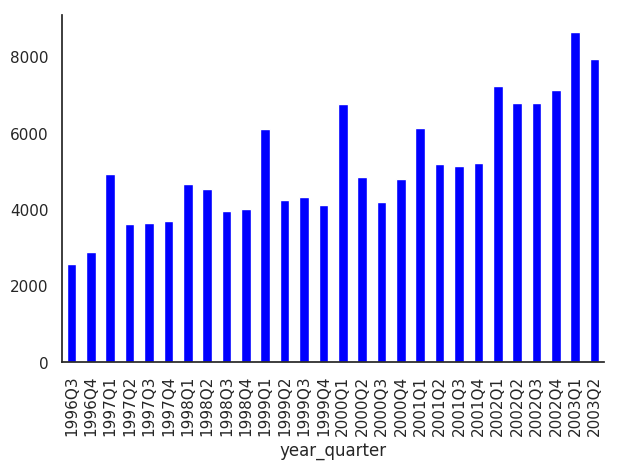

In [8]:
# you can see the data is seasonal: spikes in Q1 of every year
# and there's an upward trend
# variation seems constant
# seasonal variation also seems the same size -> additive model
ax = df['clostridium'].plot(kind='bar', color='blue')
sns.despine();

In [9]:
# fitting a Holt-Winters additive model, so there is a trend and it is seasonal
triple_smoothing = ExponentialSmoothing(
    df['clostridium'], 
    trend='additive',
    damped=False,
    seasonal='additive',
    seasonal_periods=4,
).fit()

In [10]:
# parameters of model
triple_smoothing.params

{'smoothing_level': 0.5539857383069262,
 'smoothing_slope': 1.564073106826911e-61,
 'smoothing_seasonal': 6.256292427307645e-61,
 'damping_slope': nan,
 'initial_level': 3965.5702121770923,
 'initial_slope': 175.75831059689617,
 'initial_seasons': array([-1485.44034077, -1487.60389055,   142.17630112, -1075.5944442 ]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [11]:
# adding fitted values and residuals to dataframe
df['clostridium_fitted'] = triple_smoothing.fittedvalues
df['clostridium_errors'] = triple_smoothing.resid 

In [12]:
df.head(3)

,clostridium,clostridium_fitted,clostridium_errors
year_quarter,,,
1996Q3,2569,2655.888,-86.888
1996Q4,2876,2781.348,94.652
1997Q1,4913,4639.322,273.678


In [13]:
# predicting the next 4 values
predictions = triple_smoothing.predict(end='2004Q2')
predictions

2003Q3   7577.111
2003Q4   7750.706
2004Q1   9556.244
2004Q2   8514.232
Freq: Q-DEC, dtype: float64

In [14]:
# concatenating predictions to the dataframe
df = pd.concat([df, predictions]).rename(columns={0:'clostridium_predicted'})

In [15]:
# inspecting data
df.tail(5)

,clostridium,clostridium_fitted,clostridium_errors,clostridium_predicted
2003Q2,7939.000,7652.459,286.541,nan
2003Q3,nan,nan,nan,7577.111
2003Q4,nan,nan,nan,7750.706
2004Q1,nan,nan,nan,9556.244
2004Q2,nan,nan,nan,8514.232


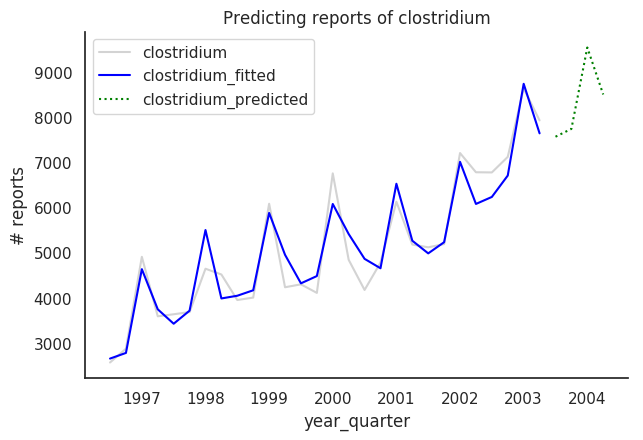

In [16]:
# plotting fitted values and predictions
ax = df[['clostridium', 'clostridium_fitted', 'clostridium_predicted']].plot(
    title='Predicting reports of clostridium',
    color=['lightgrey', 'blue', 'green'],
    style=['-', '-', ':'],
)
ax.set(xlabel='year_quarter', ylabel='# reports')
sns.despine()

In [17]:
# calculating SSE and RMSE
SSE = triple_smoothing.sse
RMSE = np.sqrt(SSE / (len(df.loc[:'2003Q2']) - 3)) # df = -3 because there 3 parameters
print(f'SSE: {SSE}\nRMSE: {RMSE}')

SSE: 4472897.467464444
RMSE: 422.9845135446188
